In [ ]:
#did Stcok market analysis for week 3 using LSTM modelling and invested in the following stocks
#1)Visa 2) UnitedHealthCare 3)XOM 4)ORCL, 5)MA

In [1]:
# libraries used 
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [6]:
#importing data
ticker= ['NVDA','AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', 'BRK-B', 'AVGO', 'WMT', 'LLY', 'JPM', 'V', 'UNH', 'XOM', 'ORCL', 'MA', 'COST', 'HD', 'PG', 'NFLX' ]
target_tickers= ['V','UNH', 'XOM', 'ORCL' ,'MA']
index=0

ticker = target_tickers

stock_data= yf.download(ticker[index], start="2023-11-1", end="2024-12-11")


#getting data of interest for stockk data
closing_prices= stock_data['Close'][ticker[index]].tolist()
opening_prices= stock_data['Open'][ticker[index]].tolist()
highs= stock_data['High'][ticker[index]].tolist()
lows= stock_data['Low'][ticker[index]].tolist()
AdjClose= stock_data['Adj Close'][ticker[index]].tolist()

#making a dataframe using the values fetched above 
stock_df= pd.DataFrame(columns=['Close'])#, 'High', 'Low', 'Close', 'AdjClose'])
stock_df['Close']= closing_prices

# processing the data

def log_transform(df):
    columns= df.columns
    transformed_df = df.copy()
    for col in columns:
        transformed_df[col] = np.log(transformed_df[col])  # log1p handles log(x + 1)
    return transformed_df

def reverse_transform(df):
    columns= df.columns
    reversed_df = df.copy()
    for col in columns:
        reversed_df[col] = np.expm1(reversed_df[col])  # Exponential minus 1
    return reversed_df
    

stock_df_transformed= log_transform(stock_df)


[*********************100%***********************]  1 of 1 completed


Epoch 1/20


/Users/pranavsharma/Desktop/VS/StockMarketAnanlysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2004 - val_loss: 0.1510
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0244 - val_loss: 0.0230
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0463
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0243
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0114
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 0.0219
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0158
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0136
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - val_loss: 0.0159
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0146
Epoch 13/20


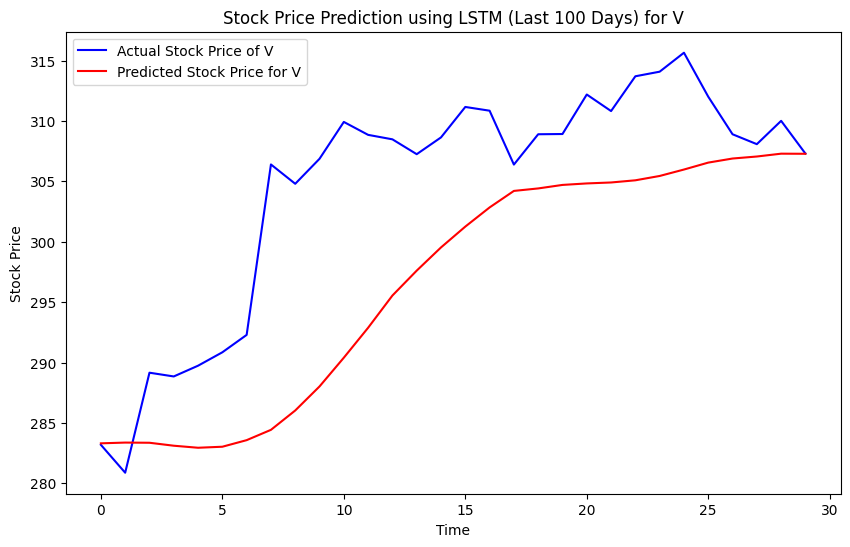

In [7]:
# Assuming your dataframe is called stock_df_transformed
# Get the 'close' prices
stock_data = stock_df_transformed['Close'].values

# Step 1: Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data.reshape(-1, 1))

# Step 2: Create sequences for training
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # past 'time_step' days
        y.append(data[i + time_step, 0])  # next day's price
    return np.array(X), np.array(y)

time_step = 10  # Look back over the past 90 days
X, y = create_dataset(stock_data_scaled, time_step)

# Reshape X to be compatible with LSTM input shape (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer for predicted stock price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Predict stock prices
predicted_stock_price = model.predict(X_test)

# Reverse the scaling for the predictions and test data
predicted_stock_price = np.expm1(scaler.inverse_transform(predicted_stock_price))
y_test_actual = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# # Step 7: Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_actual, color='blue', label=f'Actual Stock Price of {ticker[index]}')
# plt.plot(predicted_stock_price, color='red', label=f'Predicted Stock Price for {ticker[index]}')
# plt.title(f'Stock Price Prediction using LSTM for {ticker[index]}')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()

# Slice the last 100 data points for both actual and predicted prices
last_100_actual = y_test_actual[-30:]
last_100_predicted = predicted_stock_price[-30:]

# Plot the results for the last 100 days
plt.figure(figsize=(10, 6))
plt.plot(last_100_actual, color='blue', label=f'Actual Stock Price of {ticker[index]}')
plt.plot(last_100_predicted, color='red', label=f'Predicted Stock Price for {ticker[index]}')
plt.title(f'Stock Price Prediction using LSTM (Last 100 Days) for {ticker[index]}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [8]:
predicted_stock_price

array([[284.96762],
       [284.44473],
       [283.3952 ],
       [281.9252 ],
       [280.30917],
       [278.57492],
       [277.0561 ],
       [275.9628 ],
       [275.2631 ],
       [274.79858],
       [274.11795],
       [274.4193 ],
       [274.90646],
       [275.2511 ],
       [275.40198],
       [275.7173 ],
       [275.92188],
       [276.55615],
       [277.5783 ],
       [278.80362],
       [280.27512],
       [281.49762],
       [282.37158],
       [282.9853 ],
       [283.31293],
       [283.37527],
       [283.36063],
       [283.1156 ],
       [282.94696],
       [283.03162],
       [283.57617],
       [284.43002],
       [286.03223],
       [288.023  ],
       [290.4028 ],
       [292.88162],
       [295.54904],
       [297.61078],
       [299.5315 ],
       [301.2548 ],
       [302.84116],
       [304.20947],
       [304.41516],
       [304.7057 ],
       [304.82935],
       [304.9081 ],
       [305.088  ],
       [305.44696],
       [305.97946],
       [306.55322],
